# Transfer learning в решении задачи классификации цветов
Датасет классификации цветов (http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) состоит из 102 видов цветов встречаемых в Великобритании. Для каждого класса есть от 40 до 258 примеров, чего мало для обучения с нуля:
<img src="http://bennycheung.github.io/images/deep-transfer-learning-on-small-dataset/flower_train_samples_700.jpg" style="width:50%">

In [1]:
!mkdir -p input/flower-dataset-102
!wget https://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz --directory-prefix=input/flower-dataset-102
!wget https://www.robots.ox.ac.uk/~vgg/data/flowers/102/imagelabels.mat --directory-prefix=input/flower-dataset-102

--2024-03-18 22:22:45--  https://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 64:ff9b::8143:5e02, 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|64:ff9b::8143:5e02|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://thor.robots.ox.ac.uk/datasets/flowers-102/102flowers.tgz [following]
--2024-03-18 22:22:47--  https://thor.robots.ox.ac.uk/datasets/flowers-102/102flowers.tgz
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 64:ff9b::8143:5f62, 129.67.95.98
Connecting to thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)|64:ff9b::8143:5f62|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 344862509 (329M) [application/octet-stream]
Saving to: ‘input/flower-dataset-102/102flowers.tgz’

102flowers.tgz      100%[===================>] 328,89M  3,40MB/s    in 1m 45s  

2024-03-18 22:24:33 (3,13 MB/s) - ‘input/flower-dataset-102/102flowers

In [2]:
!pip install tensorflow==2.15.0

In [4]:
!pip install efficientnet

  Obtaining dependency information for efficientnet from https://files.pythonhosted.org/packages/53/97/84f88e581d6ac86dcf1ab347c497c4c568c38784e3a2bd659b96912ab793/efficientnet-1.1.1-py3-none-any.whl.metadata
  Obtaining dependency information for keras-applications<=1.0.8,>=1.0.7 from https://files.pythonhosted.org/packages/71/e3/19762fdfc62877ae9102edf6342d71b28fbfd9dea3d2f96a882ce099b03f/Keras_Applications-1.0.8-py3-none-any.whl.metadata
  Obtaining dependency information for scikit-image from https://files.pythonhosted.org/packages/f1/6c/49f5a0ce8ddcdbdac5ac69c129654938cc6de0a936303caa6cad495ceb2a/scikit_image-0.22.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for imageio>=2.27 from https://files.pythonhosted.org/packages/02/25/66533a8390e3763cf8254dee143dbf8a830391ea60d2762512ba7f9ddfbe/imageio-2.34.0-py3-none-any.whl.metadata
  Obtaining dependency information for tifffile>=2022.8.12 from https://files.pythonhosted.org/pa

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io
import tarfile
import csv
import sys
import os

In [2]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.models as M
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
import tensorflow.keras.callbacks as C
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping
from tensorflow.keras.callbacks import Callback
from tensorflow.keras import optimizers
import efficientnet.tfkeras as efn

2024-03-21 20:08:43.421072: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-21 20:08:43.421111: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-21 20:08:43.421146: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-21 20:08:43.428409: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.


In [ ]:
from sklearn.model_selection import train_test_split

import PIL
from PIL import ImageOps, ImageFilter
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
%matplotlib inline

print(os.listdir("./input"))
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)

In [4]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


2024-03-21 20:08:52.017361: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-21 20:08:52.037198: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-21 20:08:52.037451: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [5]:
# Проверяем что у нас работает GPU
tf.test.gpu_device_name()

2024-03-21 20:08:54.655238: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-21 20:08:54.655494: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-21 20:08:54.655684: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

'/device:GPU:0'

Работаем уже с Tensorflow 2.1 но для воспроизводимости сохраним версии всех пакетов

In [6]:
!pip freeze > requirements.txt

# Setup

In [58]:
# В сетап выношу основные настройки, так удобней их перебирать в дальнейшем

EPOCHS               = 5
BATCH_SIZE           = 8 # уменьшаем batch если сеть большая, иначе не влезет в память на GPU
LR                   = 1e-3
VAL_SPLIT            = 0.2

CLASS_NUM            = 102
IMG_SIZE             = 250
IMG_CHANNELS         = 3
input_shape          = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

DATA_PATH = './input/flower-dataset-102/'
PATH = "./working/flower/"

In [59]:
# Setting seed for reproducibility
#os.makedirs(PATH,exist_ok=False)

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
PYTHONHASHSEED = 0

# Data

In [9]:
# прочитаем все названия файлов прям из архива и таргеты к ним
def get_all_filenames(tar_fn):
    with tarfile.open(tar_fn) as f:
        return [m.name for m in f.getmembers() if m.isfile()]

df = pd.DataFrame()
df['Id'] = sorted(get_all_filenames(DATA_PATH+"102flowers.tgz"))
df['Category'] = scipy.io.loadmat(DATA_PATH+'imagelabels.mat')['labels'][0] - 1  # классы (0, 1, 2, ...)
df['Category'] = df['Category'].astype(str)

In [10]:
df.head(5)

,Id,Category
0,jpg/image_00001.jpg,76
1,jpg/image_00002.jpg,76
2,jpg/image_00003.jpg,76
3,jpg/image_00004.jpg,76
4,jpg/image_00005.jpg,76


In [11]:
df['Category'].value_counts()

Category
50    258
76    251
45    196
72    194
88    184
     ... 
6      40
44     40
33     40
0      40
26     40
Name: count, Length: 102, dtype: int64

In [14]:
df['Category'].nunique()

102

In [15]:
print('Распаковываем картинки')
# Will unzip the files so that you can see them..
opened_tar = tarfile.open(DATA_PATH+"102flowers.tgz")
opened_tar.extractall(PATH)

print(os.listdir(PATH+'jpg')[:5])

Распаковываем картинки
['image_06377.jpg', 'image_00682.jpg', 'image_01977.jpg', 'image_04631.jpg', 'image_05039.jpg']


Пример картинок (random sample)


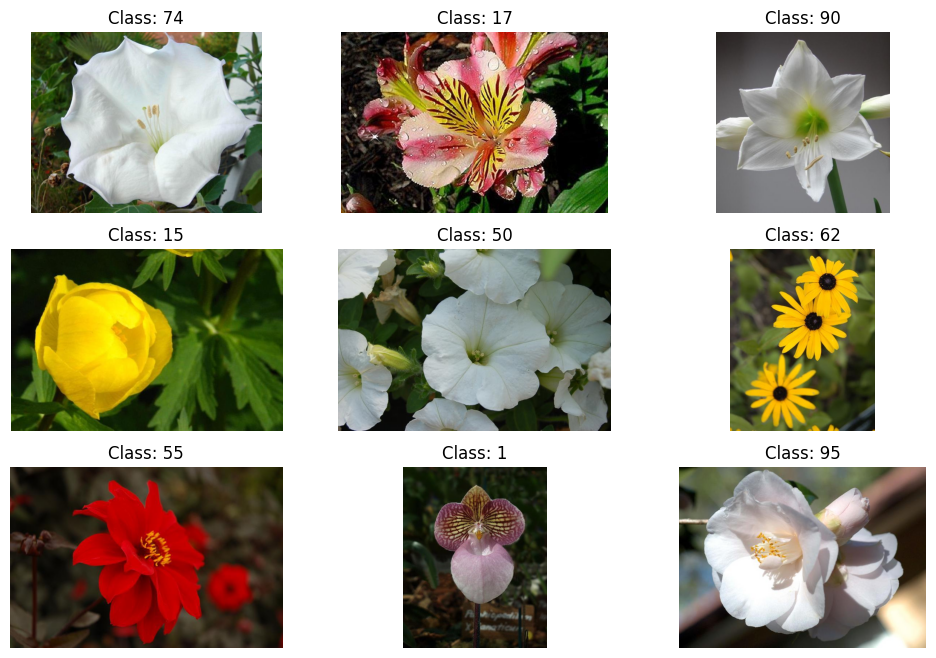

In [12]:
print('Пример картинок (random sample)')
plt.figure(figsize=(12,8))

random_image = df.sample(n=9)
random_image_paths = random_image['Id'].values
random_image_cat = random_image['Category'].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(PATH+path)
    plt.subplot(3,3, index+1)
    plt.imshow(im)
    plt.title('Class: '+str(random_image_cat[index]))
    plt.axis('off')
plt.show()

Пример картинок (random sample)


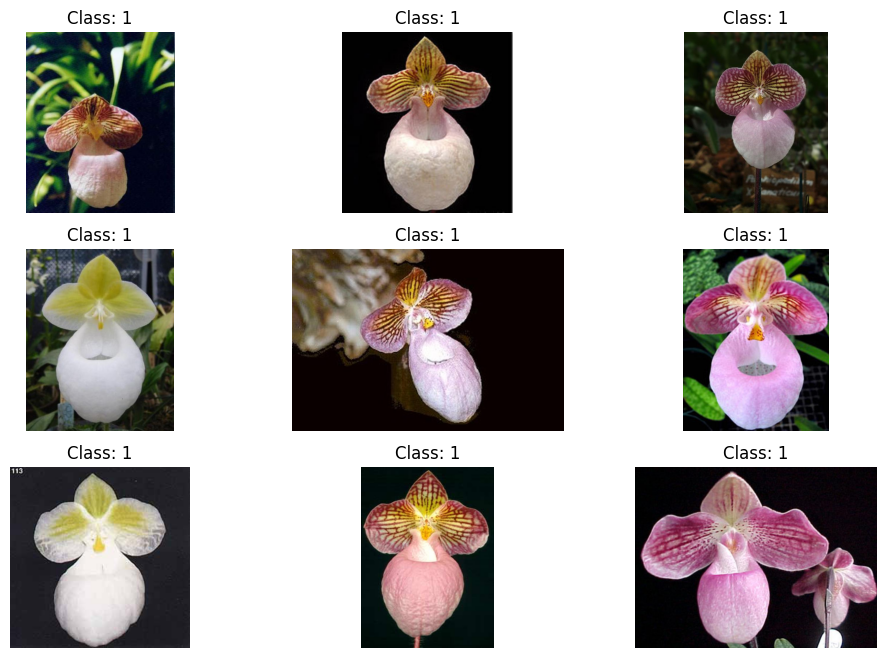

In [13]:
# убедимся что метки классов подгрузились верно
print('Пример картинок (random sample)')
plt.figure(figsize=(12,8))

random_image = df[df['Category']=='1'].sample(n=9)
random_image_paths = random_image['Id'].values
random_image_cat = random_image['Category'].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(PATH+path)
    plt.subplot(3,3, index+1)
    plt.imshow(im)
    plt.title('Class: '+str(random_image_cat[index]))
    plt.axis('off')
plt.show()

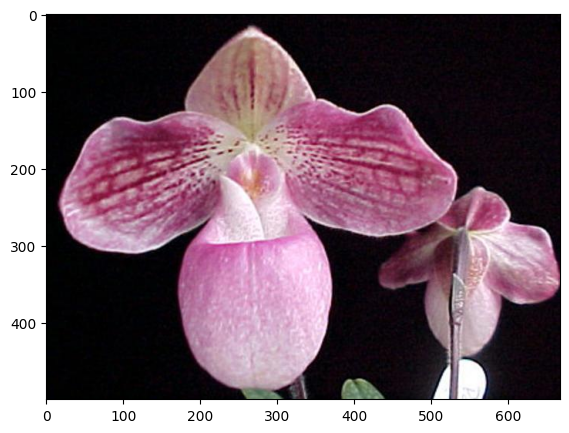

(667, 500)

In [18]:
# как видим изображения имеют разный размер
image = PIL.Image.open(PATH+path)
imgplot = plt.imshow(image)
plt.show()
image.size

 ## Stratify Split

In [14]:
# трейн / тест
train_files, test_files, train_labels, test_labels = \
    train_test_split(df['Id'], df['Category'], test_size=0.2, random_state=42, stratify=df['Category'])

train_files = pd.DataFrame(train_files)
test_files = pd.DataFrame(test_files)
train_files['Category'] = train_labels
test_files['Category'] = test_labels

train_files.shape, test_files.shape

((6551, 2), (1638, 2))

In [15]:
train_files.head(5)

,Id,Category
2361,jpg/image_02362.jpg,42
512,jpg/image_00513.jpg,87
5969,jpg/image_05970.jpg,68
6251,jpg/image_06252.jpg,60
516,jpg/image_00517.jpg,87


In [16]:
train_files['Category'].value_counts()

Category
50    206
76    201
45    157
72    155
88    147
     ... 
0      32
6      32
33     32
2      32
26     32
Name: count, Length: 102, dtype: int64

In [22]:
test_files['Category'].value_counts()

Category
50    52
76    50
72    39
45    39
88    37
      ..
78     8
0      8
20     8
24     8
66     8
Name: count, Length: 102, dtype: int64

### Data augmentation

In [52]:
# Аугментация данных очень важна когда у нас не большой датасет (как в нашем случае)

train_datagen = ImageDataGenerator(rescale=1. / 255,
                                    rotation_range = 50,
                                    shear_range=0.2,
                                    zoom_range=[0.75,1.25],
                                    brightness_range=[0.5, 1.5],
                                    width_shift_range=0.1,
                                    height_shift_range=0.1,
                                    horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1. / 255)

### datagen

In [53]:
# "Заворачиваем" наши данные в generator

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_files,
    directory=PATH,
    x_col="Id",
    y_col="Category",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=RANDOM_SEED,)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_files,
    directory=PATH,
    x_col="Id",
    y_col="Category",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
    seed=RANDOM_SEED,)

Found 6551 validated image filenames belonging to 102 classes.
Found 1638 validated image filenames belonging to 102 classes.


Пример картинок из train_generator


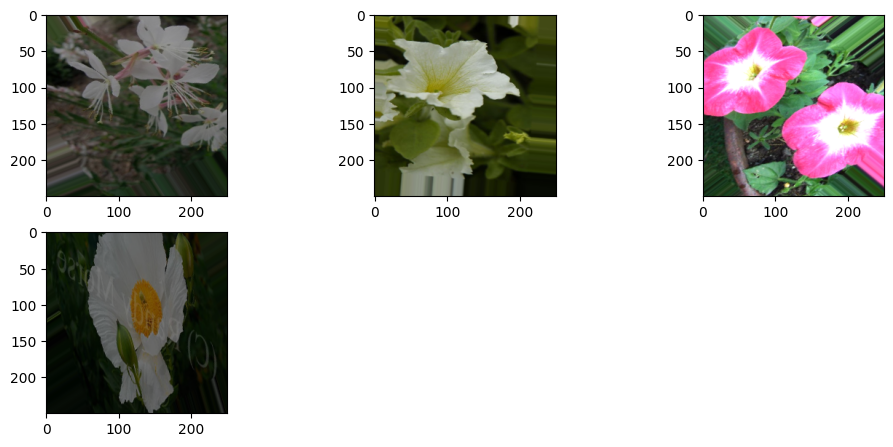

In [19]:
from skimage import io

def imshow(image_RGB):
  io.imshow(image_RGB)
  io.show()

x,y = train_generator.next()
print('Пример картинок из train_generator')
plt.figure(figsize=(12,8))

for i in range(0,4):
    image = x[i]
    plt.subplot(3,3, i+1)
    plt.imshow(image)
    #plt.title('Class: '+str(y[i]))
    #plt.axis('off')
plt.show()

Пример картинок из test_generator


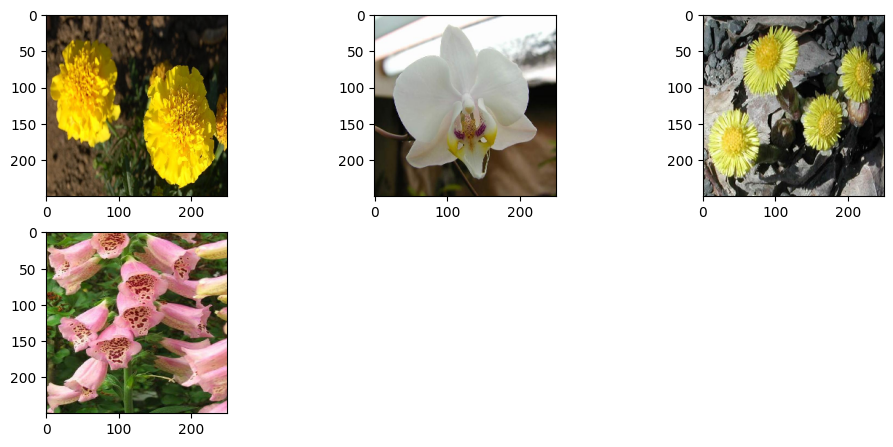

In [26]:
x,y = test_generator.next()
print('Пример картинок из test_generator')
plt.figure(figsize=(12,8))

for i in range(0,4):
    image = x[i]
    plt.subplot(3,3, i+1)
    plt.imshow(image)
    #plt.title('Class: '+str(y[i]))
    #plt.axis('off')
plt.show()

# Model

In [20]:
input_shape

(250, 250, 3)

In [60]:
base_model = efn.EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)

In [22]:
base_model.summary()

Model: "efficientnet-b0"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 250, 250, 3)]        0         []                            
                                                                                                  
 stem_conv (Conv2D)          (None, 125, 125, 32)         864       ['input_1[0][0]']             
                                                                                                  
 stem_bn (BatchNormalizatio  (None, 125, 125, 32)         128       ['stem_conv[0][0]']           
 n)                                                                                               
                                                                                                  
 stem_activation (Activatio  (None, 125, 125, 32)         0         ['stem_bn[0][0]'

In [61]:
# first: train only the top layers (which were randomly initialized)
base_model.trainable = False

In [62]:
model=M.Sequential()
model.add(base_model)
model.add(L.GlobalAveragePooling2D(),)
model.add(L.Dense(CLASS_NUM, activation='softmax'))

In [63]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet-b0 (Functiona  (None, 8, 8, 1280)        4049564   
 l)                                                              
                                                                 
 global_average_pooling2d_1  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_1 (Dense)             (None, 102)               130662    
                                                                 
Total params: 4180226 (15.95 MB)
Trainable params: 130662 (510.40 KB)
Non-trainable params: 4049564 (15.45 MB)
_________________________________________________________________


In [64]:
# сколько слоев
print(len(model.layers))

3


In [65]:
len(model.trainable_variables)

2

In [66]:
# Check the trainable status of the individual layers
for layer in model.layers:
    print(layer, layer.trainable)

<keras.src.engine.functional.Functional object at 0x7f683fbfa890> False
<keras.src.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x7f683fb4ce50> True
<keras.src.layers.core.dense.Dense object at 0x7f683f926b90> True


## Fit

In [67]:
LR=0.001
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=LR), metrics=["accuracy"])

In [68]:
checkpoint = ModelCheckpoint('best_model.hdf5' , monitor = ['val_accuracy'] , verbose = 1  , mode = 'max')
earlystop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
callbacks_list = [checkpoint, earlystop]

In [50]:
scores = model.evaluate_generator(test_generator, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

/tmp/ipykernel_4995/1370569445.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  scores = model.evaluate_generator(test_generator, verbose=1)
2024-03-19 21:36:58.216752: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8201


 10/205 [>.............................] - ETA: 4s - loss: 4.7480 - accuracy: 0.0125

2024-03-19 21:37:00.628553: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


205/205 [==============================] - 8s 19ms/step - loss: 4.7228 - accuracy: 0.0067
Accuracy: 0.67%


In [69]:
# Обучаем
history = model.fit_generator(
                    train_generator,
                    steps_per_epoch = train_generator.samples//train_generator.batch_size,
                    validation_data = test_generator,
                    validation_steps = test_generator.samples//test_generator.batch_size,
                    epochs = EPOCHS,
                    callbacks = callbacks_list
                    )

Epoch 1/5


/tmp/ipykernel_3383/2148587772.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


818/818 [==============================] - ETA: 0s - loss: 2.0338 - accuracy: 0.5733
Epoch 1: saving model to best_model.hdf5


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


818/818 [==============================] - 72s 84ms/step - loss: 2.0338 - accuracy: 0.5733 - val_loss: 0.8135 - val_accuracy: 0.8321
Epoch 2/5
818/818 [==============================] - ETA: 0s - loss: 0.8606 - accuracy: 0.8041
Epoch 2: saving model to best_model.hdf5
818/818 [==============================] - 66s 81ms/step - loss: 0.8606 - accuracy: 0.8041 - val_loss: 0.4857 - val_accuracy: 0.8873
Epoch 3/5
818/818 [==============================] - ETA: 0s - loss: 0.6137 - accuracy: 0.8533
Epoch 3: saving model to best_model.hdf5
818/818 [==============================] - 67s 81ms/step - loss: 0.6137 - accuracy: 0.8533 - val_loss: 0.3883 - val_accuracy: 0.9081
Epoch 4/5
818/818 [==============================] - ETA: 0s - loss: 0.4727 - accuracy: 0.8872
Epoch 4: saving model to best_model.hdf5
818/818 [==============================] - 66s 81ms/step - loss: 0.4727 - accuracy: 0.8872 - val_loss: 0.3179 - val_accuracy: 0.9265
Epoch 5/5
818/818 [==============================] - ETA: 0s

In [ ]:
def plot_history(history):
    plt.figure(figsize=(10,5))
    #plt.style.use('dark_background')
    acc = history['accuracy']
    val_acc = history['val_accuracy']
    loss = history['loss']
    val_loss = history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'g', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    #plt.figure()
    plt.figure(figsize=(10,5))
    #plt.style.use('dark_background')
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'g', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

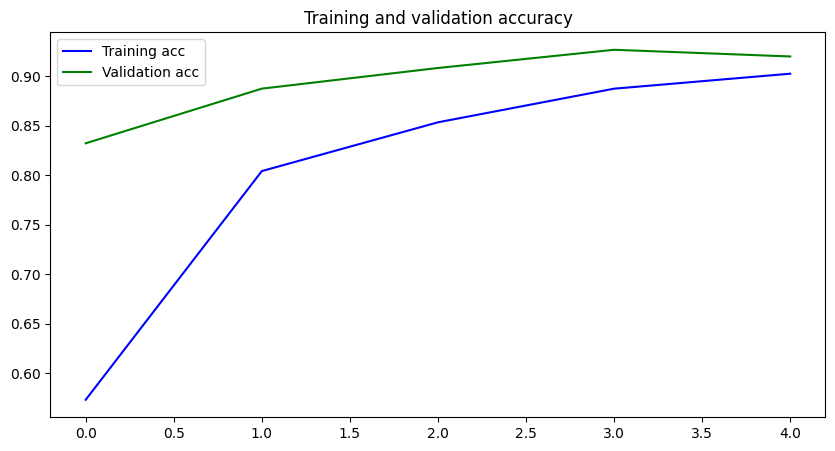

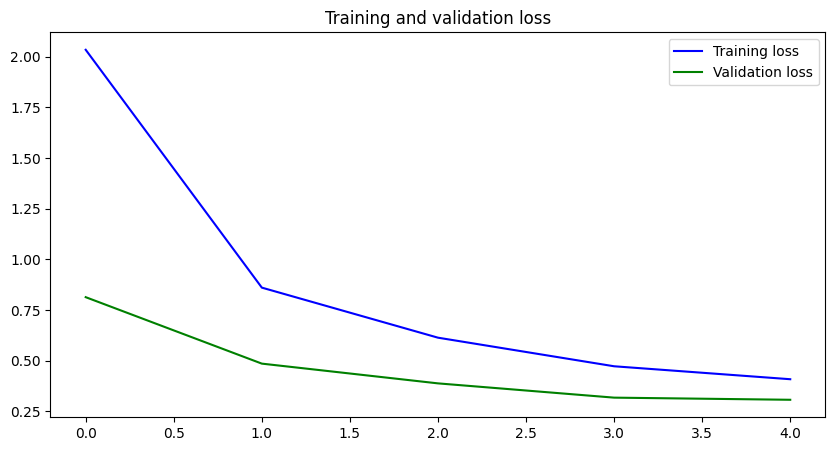

In [70]:
plot_history(history.history)

In [71]:
model.save('./working/model_step1.hdf5')
model.load_weights('best_model.hdf5')

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [72]:
scores = model.evaluate_generator(test_generator, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

  4/205 [..............................] - ETA: 3s - loss: 0.3019 - accuracy: 0.9375 

/tmp/ipykernel_3383/1370569445.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  scores = model.evaluate_generator(test_generator, verbose=1)


205/205 [==============================] - 4s 19ms/step - loss: 0.3077 - accuracy: 0.9194
Accuracy: 91.94%


## Step 2

In [55]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  230


In [73]:
base_model.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = len(base_model.layers)//2

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

In [74]:
len(base_model.trainable_variables)

104

In [75]:
# Check the trainable status of the individual layers
for layer in model.layers:
    print(layer, layer.trainable)

<keras.src.engine.functional.Functional object at 0x7f683fbfa890> True
<keras.src.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x7f683fb4ce50> True
<keras.src.layers.core.dense.Dense object at 0x7f683f926b90> True


In [76]:
LR=0.0001
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=LR), metrics=["accuracy"])

In [77]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet-b0 (Functiona  (None, 8, 8, 1280)        4049564   
 l)                                                              
                                                                 
 global_average_pooling2d_1  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_1 (Dense)             (None, 102)               130662    
                                                                 
Total params: 4180226 (15.95 MB)
Trainable params: 3790190 (14.46 MB)
Non-trainable params: 390036 (1.49 MB)
_________________________________________________________________


In [78]:
scores = model.evaluate_generator(test_generator, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

/tmp/ipykernel_3383/1370569445.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  scores = model.evaluate_generator(test_generator, verbose=1)


205/205 [==============================] - 6s 19ms/step - loss: 0.3077 - accuracy: 0.9194
Accuracy: 91.94%


In [79]:
# Обучаем
history = model.fit_generator(
        train_generator,
        steps_per_epoch = train_generator.samples//train_generator.batch_size,
        validation_data = test_generator,
        validation_steps = test_generator.samples//test_generator.batch_size,
        epochs = EPOCHS,
        callbacks = callbacks_list
)

Epoch 1/5


/tmp/ipykernel_3383/738513846.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(
2024-03-21 21:11:21.173463: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/efficientnet-b0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


818/818 [==============================] - ETA: 0s - loss: 0.7741 - accuracy: 0.7836
Epoch 1: saving model to best_model.hdf5
818/818 [==============================] - 78s 81ms/step - loss: 0.7741 - accuracy: 0.7836 - val_loss: 0.4440 - val_accuracy: 0.8824
Epoch 2/5
818/818 [==============================] - ETA: 0s - loss: 0.3897 - accuracy: 0.8867
Epoch 2: saving model to best_model.hdf5
818/818 [==============================] - 67s 82ms/step - loss: 0.3897 - accuracy: 0.8867 - val_loss: 0.3847 - val_accuracy: 0.8995
Epoch 3/5
818/818 [==============================] - ETA: 0s - loss: 0.3411 - accuracy: 0.8985
Epoch 3: saving model to best_model.hdf5
818/818 [==============================] - 67s 82ms/step - loss: 0.3411 - accuracy: 0.8985 - val_loss: 0.4851 - val_accuracy: 0.8940
Epoch 4/5
818/818 [==============================] - ETA: 0s - loss: 0.2556 - accuracy: 0.9266
Epoch 4: saving model to best_model.hdf5
818/818 [==============================] - 67s 82ms/step - loss: 0.

In [80]:
model.save('./working/model_step2.hdf5')
model.load_weights('best_model.hdf5')

In [81]:
scores = model.evaluate_generator(test_generator, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

  4/205 [..............................] - ETA: 4s - loss: 0.2358 - accuracy: 0.9375 

/tmp/ipykernel_3383/1370569445.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  scores = model.evaluate_generator(test_generator, verbose=1)


205/205 [==============================] - 4s 18ms/step - loss: 0.3567 - accuracy: 0.9139
Accuracy: 91.39%


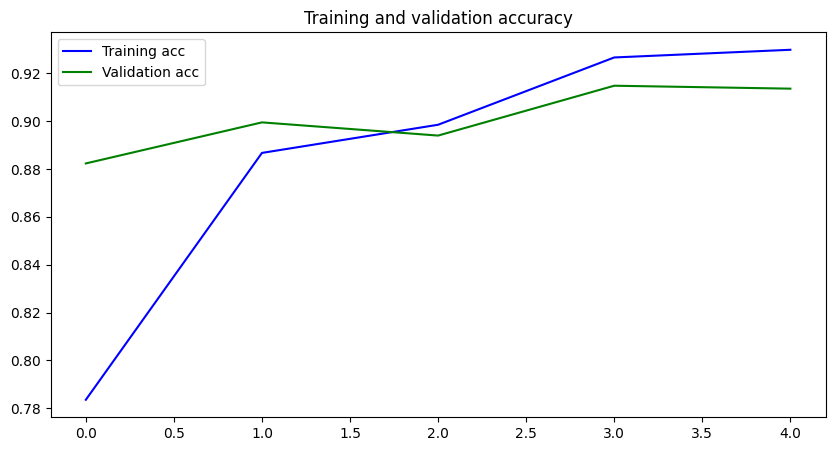

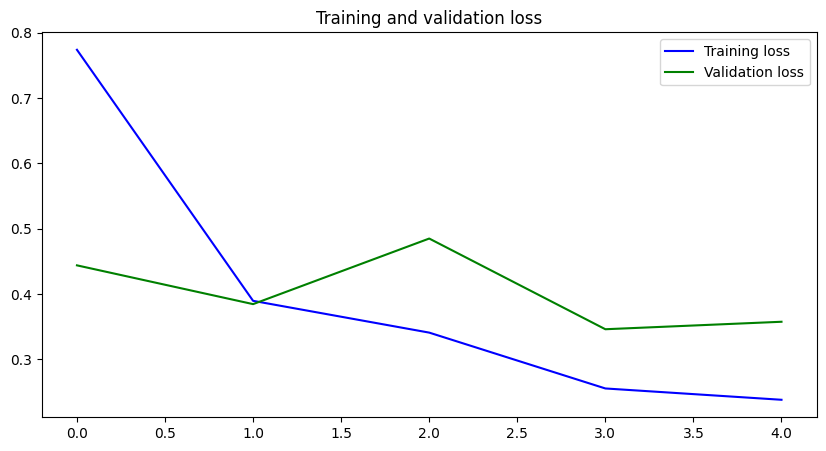

In [83]:
plot_history(history.history)

## Step 3

In [84]:
model.load_weights('best_model.hdf5')

In [85]:
base_model.trainable = True

In [86]:
LR=0.00001
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=LR), metrics=["accuracy"])

In [69]:
# Обучаем
history = model.fit_generator(
        train_generator,
        steps_per_epoch = train_generator.samples//train_generator.batch_size,
        validation_data = test_generator,
        validation_steps = test_generator.samples//test_generator.batch_size,
        epochs = EPOCHS,
        callbacks = callbacks_list
)

Epoch 1/5


/tmp/ipykernel_4995/738513846.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(
2024-03-19 21:55:29.568861: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/efficientnet-b0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


818/818 [==============================] - ETA: 0s - loss: 0.3351 - accuracy: 0.8947
Epoch 1: saving model to best_model.hdf5
818/818 [==============================] - 85s 80ms/step - loss: 0.3351 - accuracy: 0.8947 - val_loss: 0.4537 - val_accuracy: 0.8909
Epoch 2/5
818/818 [==============================] - ETA: 0s - loss: 0.2692 - accuracy: 0.9213
Epoch 2: saving model to best_model.hdf5
818/818 [==============================] - 67s 82ms/step - loss: 0.2692 - accuracy: 0.9213 - val_loss: 0.3528 - val_accuracy: 0.9142
Epoch 3/5
818/818 [==============================] - ETA: 0s - loss: 0.2303 - accuracy: 0.9294
Epoch 3: saving model to best_model.hdf5
818/818 [==============================] - 65s 80ms/step - loss: 0.2303 - accuracy: 0.9294 - val_loss: 0.5033 - val_accuracy: 0.8860
Epoch 4/5
818/818 [==============================] - ETA: 0s - loss: 0.1836 - accuracy: 0.9438
Epoch 4: saving model to best_model.hdf5
818/818 [==============================] - 68s 83ms/step - loss: 0.

In [88]:
model.save('./working/model_step3.hdf5')
model.load_weights('best_model.hdf5')

In [89]:
scores = model.evaluate_generator(test_generator, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

/tmp/ipykernel_3383/1370569445.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  scores = model.evaluate_generator(test_generator, verbose=1)


205/205 [==============================] - 5s 19ms/step - loss: 0.3341 - accuracy: 0.9304
Accuracy: 93.04%


# Step 4

In [90]:
EPOCHS               = 10
BATCH_SIZE           = 4 # уменьшаем batch если сеть большая, иначе не влезет в память на GPU
LR                   = 1e-4

IMG_SIZE             = 512
IMG_CHANNELS         = 3
input_shape          = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

In [91]:
train_datagen = ImageDataGenerator(rescale=1. / 255,
                                    #rotation_range = 90,
                                    #shear_range=0.2,
                                    zoom_range=[0.75,1.25],
                                    #brightness_range=[0.5, 1.5],
                                    #width_shift_range=0.1,
                                    #height_shift_range=0.1,
                                    horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1. / 255)

In [92]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_files,
    directory=PATH,
    x_col="Id",
    y_col="Category",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=RANDOM_SEED,)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_files,
    directory=PATH,
    x_col="Id",
    y_col="Category",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
    seed=RANDOM_SEED,)

Found 6551 validated image filenames belonging to 102 classes.
Found 1638 validated image filenames belonging to 102 classes.


In [93]:
base_model = efn.EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)

In [32]:
model=M.Sequential()
model.add(base_model)
model.add(L.GlobalAveragePooling2D(),)
model.add(L.Dense(CLASS_NUM, activation='softmax'))

In [94]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet-b0 (Functiona  (None, 8, 8, 1280)        4049564   
 l)                                                              
                                                                 
 global_average_pooling2d_1  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_1 (Dense)             (None, 102)               130662    
                                                                 
Total params: 4180226 (15.95 MB)
Trainable params: 4138210 (15.79 MB)
Non-trainable params: 42016 (164.12 KB)
_________________________________________________________________


In [95]:
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=LR), metrics=["accuracy"])

In [96]:
model.load_weights('best_model.hdf5')

In [35]:
# Обучаем
history = model.fit_generator(
        train_generator,
        steps_per_epoch = train_generator.samples//train_generator.batch_size,
        validation_data = test_generator,
        validation_steps = test_generator.samples//test_generator.batch_size,
        epochs = EPOCHS,
        callbacks = callbacks_list
        )

Epoch 1/10


/tmp/ipykernel_47676/930636693.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(
2024-03-19 23:53:06.498174: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/efficientnet-b0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-03-19 23:53:08.431515: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8201
2024-03-19 23:53:10.205087: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-03-19 23:53:10.238109: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x3110d590 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-19 2

1637/1637 [==============================] - ETA: 0s - loss: 1.7630 - accuracy: 0.5670
Epoch 1: saving model to best_model.hdf5
1637/1637 [==============================] - 244s 135ms/step - loss: 1.7630 - accuracy: 0.5670 - val_loss: 0.7166 - val_accuracy: 0.8307
Epoch 2/10
1637/1637 [==============================] - ETA: 0s - loss: 0.6026 - accuracy: 0.8303
Epoch 2: saving model to best_model.hdf5
1637/1637 [==============================] - 209s 128ms/step - loss: 0.6026 - accuracy: 0.8303 - val_loss: 0.5176 - val_accuracy: 0.8796
Epoch 3/10
1637/1637 [==============================] - ETA: 0s - loss: 0.4242 - accuracy: 0.8815
Epoch 3: saving model to best_model.hdf5
1637/1637 [==============================] - 207s 126ms/step - loss: 0.4242 - accuracy: 0.8815 - val_loss: 0.5644 - val_accuracy: 0.8649
Epoch 4/10
1637/1637 [==============================] - ETA: 0s - loss: 0.3235 - accuracy: 0.9080
Epoch 4: saving model to best_model.hdf5
1637/1637 [==============================] -

In [105]:
model.save('./working/model_step4.hdf5')
model.load_weights('best_model.hdf5')

In [106]:
scores = model.evaluate_generator(test_generator, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

  1/410 [..............................] - ETA: 38s - loss: 0.0030 - accuracy: 1.0000

/tmp/ipykernel_3383/1370569445.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  scores = model.evaluate_generator(test_generator, verbose=1)


410/410 [==============================] - 14s 35ms/step - loss: 0.2518 - accuracy: 0.9493
Accuracy: 94.93%


# Final Score

In [107]:
from sklearn.metrics import accuracy_score

In [108]:
predictions = model.predict_generator(test_generator, verbose=1)
predictions = np.argmax(predictions, axis=-1) #multiple categories
label_map = (train_generator.class_indices)
label_map = dict((v,k) for k,v in label_map.items()) #flip k,v
predictions = [label_map[k] for k in predictions]

/tmp/ipykernel_3383/1023554823.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model.predict_generator(test_generator, verbose=1)


410/410 [==============================] - 14s 33ms/step


In [109]:
filenames_with_dir=test_generator.filenames
submission = pd.DataFrame({'Predict':predictions}, columns=['Predict'], index=filenames_with_dir)
test_files.index = test_files['Id']
tmp_y = pd.concat([submission['Predict'], test_files['Category']], axis=1, sort=False)
tmp_y.head(5)

,Predict,Category
jpg/image_05001.jpg,46,46
jpg/image_07204.jpg,6,6
jpg/image_04014.jpg,11,11
jpg/image_07420.jpg,93,93
jpg/image_01122.jpg,45,45


In [110]:
print('Accuracy: %.2f%%' % (accuracy_score(tmp_y['Category'], tmp_y['Predict'],)*100))

Accuracy: 94.93%


# TTA

In [47]:
model.load_weights('best_model.hdf5')

In [111]:
test_datagen = ImageDataGenerator(rescale=1. / 255,
                                 rotation_range = 90,
                                    shear_range=0.2,
                                    zoom_range=[0.75,1.25],
                                    brightness_range=[0.5, 1.5],
                                    width_shift_range=0.1,
                                    height_shift_range=0.1,)

In [112]:
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_files,
    directory=PATH,
    x_col="Id",
    y_col="Category",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
    seed=RANDOM_SEED,)

Found 1638 validated image filenames belonging to 102 classes.


Пример картинок из test_generator


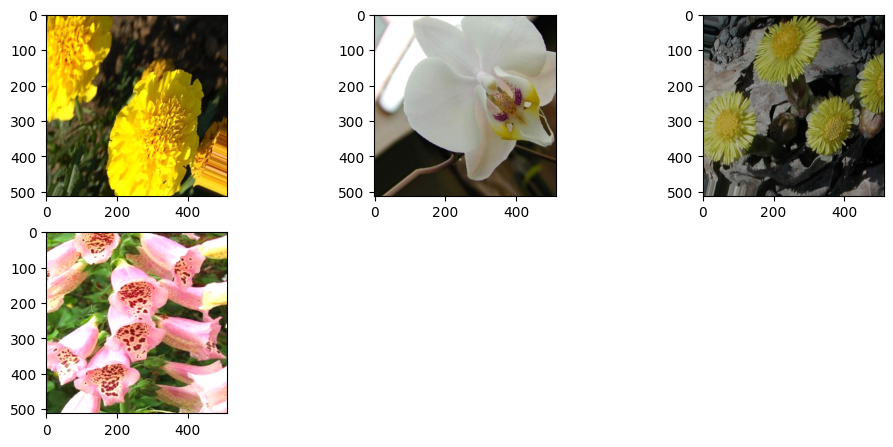

In [113]:
x,y = test_generator.next()
print('Пример картинок из test_generator')
plt.figure(figsize=(12,8))

for i in range(0,4):
    image = x[i]
    plt.subplot(3,3, i+1)
    plt.imshow(image)
plt.show()

In [114]:
tta_steps = 10
predictions = []

for i in range(tta_steps):
    preds = model.predict_generator(test_generator, verbose=1)
    predictions.append(preds)

pred = np.mean(predictions, axis=0)

/tmp/ipykernel_3383/699072576.py:5: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  preds = model.predict_generator(test_generator, verbose=1)


410/410 [==============================] - 59s 143ms/step


In [115]:
predictions = np.argmax(pred, axis=-1) #multiple categories
label_map = (train_generator.class_indices)
label_map = dict((v,k) for k,v in label_map.items()) #flip k,v
predictions = [label_map[k] for k in predictions]
filenames_with_dir=test_generator.filenames
submission = pd.DataFrame({'Predict':predictions}, columns=['Predict'], index=filenames_with_dir)
tmp_y = pd.concat([submission['Predict'], test_files['Category']], axis=1, sort=False)

In [116]:
print('Accuracy: %.2f%%' % (accuracy_score(tmp_y['Category'], tmp_y['Predict'],)*100))

Accuracy: 94.87%


## clean

In [81]:
# Clean PATH
import shutil
shutil.rmtree(PATH)